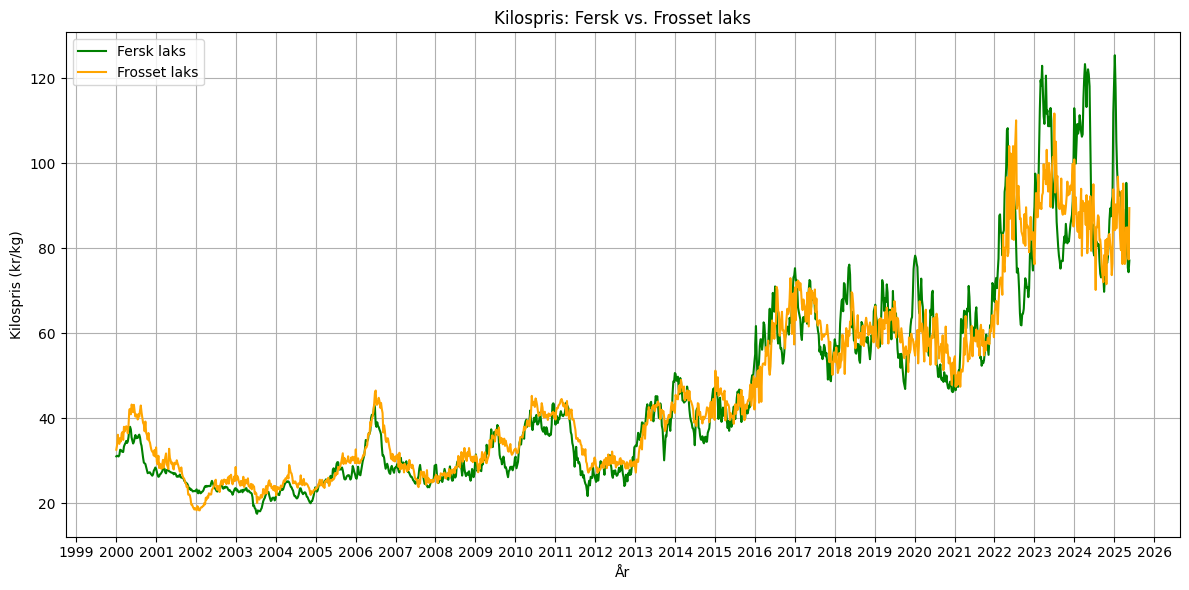

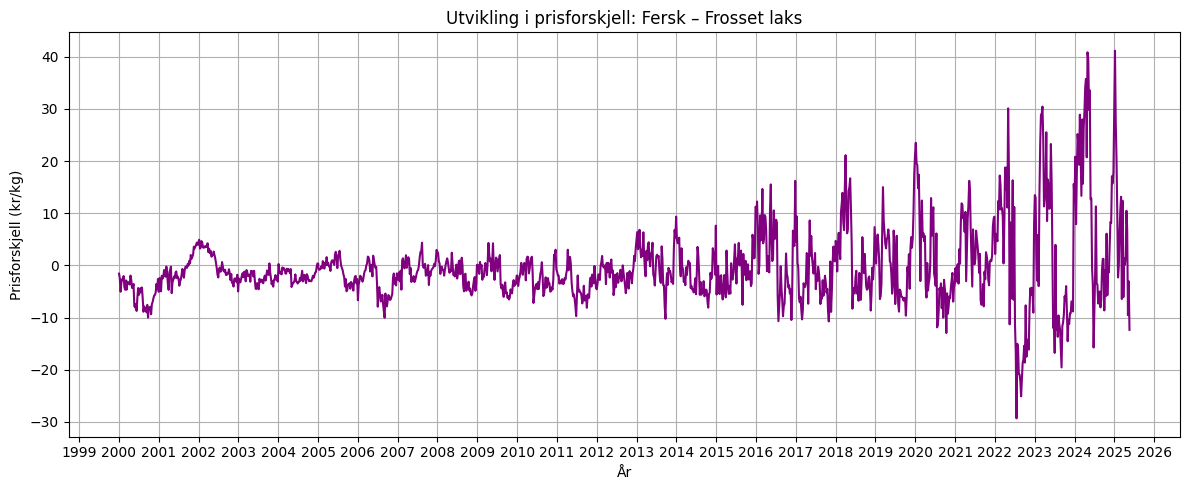

'\n    Merk: Rensing av manglende verdier (NaN) er allerede demonstrert i en egen datarensingfil.\n'

In [2]:
""" 
    Denne filen henter og prosesserer data fra SSB.
    Filen visualiserer:
        Utviklingen i kilopris for fersk og frosset laks.
        Utviklingen i prisforskjell mellom fersk og frosset laks.

    Dataene konverteres til ukedatoer og renses for manglende verdier før visualisering.
    Denne filen fokuserer på å isualisere og sammenligne utviklingen i kilospris.
"""


import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Henter og prosesserer data fra SSB
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot #returnerer en DataFrame med kolonnene: "UkeID", "Fersk laks - Kilospris", "Frosset laks - Kilospris"

#Lager en funksjon som viser sammenligning og utvikling i prisforskjell 
def analyser_fersk_vs_frosset_plot():
    df = hent_eksportdata()
    df = df.dropna() #Dataene renses for manglende verdier 

    #Konverter ukeID til mandag i hver uke
    df["UkeDato"] = pd.to_datetime(df["UkeID"] + "-1", format="%Y-%W-%w")

    #Plot 1: Sammenligning av prisene for fersk og frosset laks 
    plt.figure(figsize=(12, 6))
    plt.plot(df["UkeDato"], df["Fersk laks - Kilospris"], label="Fersk laks", color="green")
    plt.plot(df["UkeDato"], df["Frosset laks - Kilospris"], label="Frosset laks", color="orange")
    plt.xlabel("År")
    plt.ylabel("Kilospris (kr/kg)")
    plt.title("Kilospris: Fersk vs. Frosset laks")
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.show()

    #Plot 2: Prisforskjell mellom fersk og frosset laks
    df["Prisforskjell"] = df["Fersk laks - Kilospris"] - df["Frosset laks - Kilospris"]

    plt.figure(figsize=(12, 5))
    plt.plot(df["UkeDato"], df["Prisforskjell"], color="purple")
    plt.xlabel("År")
    plt.ylabel("Prisforskjell (kr/kg)")
    plt.title("Utvikling i prisforskjell: Fersk – Frosset laks")
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.show()

#Denne grafen brukes til å vurdere om prisforskjellen mellom fersk og frosset laks endrer seg systematisk over tid.


if __name__ == "__main__":
    analyser_fersk_vs_frosset_plot() 

"""
    Merk: Rensing av manglende verdier (NaN) er allerede demonstrert i en egen datarensingfil.
"""

Utfra det første plottet kan vi se at forholdet mellom kilosprisen for både fersk og frosset laks har vært relativt jevn på starten av 2000 tallet, men at den øker og blir mer "ustabil" etter ca. 2016 for begge varetypene, og spesielt variabel etter 2020 og frem til i dag. Dette støttes av plot 2 som viser utviklingen i prisforskjell for både fersk og frosset laks. Grafen er relativt jevn til å begynne med, men blir mer og mer turbulent i de senere årene. 
Vi vil senere undersøke hva grunnen til dette kan være, ved å sammenligne valutakurser med kilospris. 

In [3]:
"""
    Denne filen henter data om lakseeksport fra SSB, og utfører en statistisk analyse på kilopris for fersk og frosset laks. 
    Koden beregner gjennomsnitt, median og standardavvik for hvert år og for hver sesong som vises i tabeller med farger.
    Mørkere farger indikerer høyere verdier i tabellene.
"""


import requests
import pandas as pd
from itertools import product
from IPython.display import display

# Definerer stil for tabeller
pen_stil = [
    {"selector": "th, td", "props": [("padding", "8px 12px"), ("border", "1px solid #ddd"), ("color", "#000")]},
    {"selector": "th", "props": [("background-color", "#f0f0f0"), ("text-align", "center")]},
    {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("margin-bottom", "10px")]}
]

# Henter og prosesserer data fra SSB
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values

    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["UkeID"] + "-1", format="%Y-%W-%w")
    return df_pivot.dropna()

# Statistikk per år (tabellvisning)
def vis_statistikk_per_år(df):
    """
        Tar inn en DataFrame med uke-dato og priser og lager tabeller med
        gjennomsnitt, median og standardavvik for hvert år. 
        Det er en tabell hver for fersk og frosset laks.
    """
    df["År"] = df["UkeDato"].dt.year

    stats_fersk = df.groupby("År")["Fersk laks - Kilospris"].agg(["mean", "median", "std"]).round(2)
    stats_frosset = df.groupby("År")["Frosset laks - Kilospris"].agg(["mean", "median", "std"]).round(2)

    stats_fersk.columns = ["Gjennomsnitt", "Median", "Std.avvik"]
    stats_frosset.columns = ["Gjennomsnitt", "Median", "Std.avvik"]

    print("\n Statistikk for fersk laks (kr/kg):")
    display(stats_fersk.style
            .set_caption("Fersk laks, per år")
            .format("{:.2f}")
            .background_gradient(cmap="Greens")
            .set_table_styles(pen_stil))

    print("\n Statistikk for frosset laks (kr/kg):")
    display(stats_frosset.style
            .set_caption("Frosset laks, per år")
            .format("{:.2f}")
            .background_gradient(cmap="Blues")
            .set_table_styles(pen_stil))

#Statistikk per sesong (tabellvisning)
def vis_statistikk_per_sesong(df):
    """
        Tar inn en DataFrame med uke-dato og priser og lager tabeller med
        gjennomsnitt, median og standardavvik for hver sesong: vinter, vår, sommer, høst.
        Ferk og frosset laks har hver sin tabell.
    """

    def finn_sesong(mnd):
        if mnd in [3, 4, 5]: return "Vår"
        elif mnd in [6, 7, 8]: return "Sommer"
        elif mnd in [9, 10, 11]: return "Høst"
        else: return "Vinter"

    df["Sesong"] = df["UkeDato"].dt.month.map(finn_sesong)

    stats_fersk = df.groupby("Sesong")["Fersk laks - Kilospris"].agg(["mean", "median", "std"]).round(2)
    stats_frosset = df.groupby("Sesong")["Frosset laks - Kilospris"].agg(["mean", "median", "std"]).round(2)

    stats_fersk.columns = ["Gjennomsnitt", "Median", "Std.avvik"]
    stats_frosset.columns = ["Gjennomsnitt", "Median", "Std.avvik"]

    stats_fersk = stats_fersk.reindex(["Vinter", "Vår", "Sommer", "Høst"])
    stats_frosset = stats_frosset.reindex(["Vinter", "Vår", "Sommer", "Høst"])

    print("\n Statistikk per sesong for fersk laks:")
    display(stats_fersk.style
            .set_caption("Fersk laks, per sesong")
            .format("{:.2f}")
            .background_gradient(cmap="Greens")
            .set_table_styles(pen_stil))

    print("\n Statistikk per sesong for frosset laks:")
    display(stats_frosset.style
            .set_caption("Frosset laks, per sesong")
            .format("{:.2f}")
            .background_gradient(cmap="Blues")
            .set_table_styles(pen_stil))

#Kjører alt sammen
if __name__ == "__main__":
    df = hent_eksportdata()
    vis_statistikk_per_år(df)
    vis_statistikk_per_sesong(df)



 Statistikk for fersk laks (kr/kg):


,Gjennomsnitt,Median,Std.avvik
År,,,
2000,32.04,32.33,3.40
2001,25.99,26.45,1.67
2002,23.36,23.38,0.70
2003,21.24,21.75,1.81
2004,22.55,22.42,1.36
2005,26.17,25.98,1.70
2006,32.41,30.92,5.14
2007,26.68,26.48,1.87
2008,27.02,26.81,1.48



 Statistikk for frosset laks (kr/kg):


,Gjennomsnitt,Median,Std.avvik
År,,,
2000,37.44,37.14,3.54
2001,26.96,28.34,3.90
2002,23.02,23.80,2.69
2003,23.65,23.94,1.48
2004,24.50,24.44,1.48
2005,27.10,26.49,2.61
2006,35.80,34.58,5.34
2007,27.26,27.42,2.04
2008,28.62,28.24,2.21



 Statistikk per sesong for fersk laks:


,Gjennomsnitt,Median,Std.avvik
Sesong,,,
Vinter,46.86,39.71,24.96
Vår,50.02,39.75,26.90
Sommer,44.50,38.50,20.25
Høst,40.59,34.44,18.15



 Statistikk per sesong for frosset laks:


,Gjennomsnitt,Median,Std.avvik
Sesong,,,
Vinter,44.80,40.07,20.69
Vår,47.10,41.10,21.39
Sommer,47.31,41.64,21.37
Høst,44.68,39.56,19.53


Denne visualiseringsmåten i tabeller gjør det enkelt å se hvilke år og sesonger det har vært høyest og lavest kilospris, samt når det har vært størst endringer. De lyseste verdiene i alle tabellene indikerer lave verdier, mens de mørkeste er de høyeste verdiene. Dette støtter de to tidligere plottene som sier at det har vært størst variasjon, prisendring og -økning de siste årene. 